<a href="https://colab.research.google.com/github/Abudhagir/3D-Vision/blob/main/3DVSS_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to PyTorch Geometric

> PyTorch Geometric (PyG) is a library built upon PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data.

> It consists of various methods for deep learning on graphs and other irregular structures, also known as geometric deep learning, from a variety of published papers.

> In addition, it consists of easy-to-use mini-batch loaders for operating on many small and single giant graphs, multi GPU-support, distributed graph learning via Quiver, a large number of common benchmark datasets (based on simple interfaces to create your own), the GraphGym experiment manager, and helpful transforms, both for learning on arbitrary graphs as well as on 3D meshes or point clouds.

Source: https://pytorch-geometric.readthedocs.io/en/latest/

## 0. Install PyG

In [1]:
import torch
torch.__version__

'2.0.0+cu118'

In [2]:
# Install PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 66.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## 1. Dataset Insight

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Import dataset
dataset = Planetoid(root="./data/", name="Cora")
# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [ ]:
print(f"No of graphs = {len(dataset)}")

No of graphs = 1


In [ ]:
data = dataset[0] # Get the first graph object here only one
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# Handling graph data in PyG

A graph in PyG is represented by an instance of [`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data). This `Data` objects have the following attributes:

```
data.x: node feature matrix of shape [num_nodes, num_node_features]
data.edge_index: matrix of edge (u, v) transposed; [2, num_edges]
data.edge_attr: edge features of shape [num_edges, num_edge_features]
data.y: target for the graph; this can be single value or per-node value
```

> None of these attributes are required. In fact, the `Data` object is not even restricted to these attributes. We can, e.g., extend it by `data.face` to save the connectivity of triangles from a 3D mesh in a tensor with shape `[3, num_faces]` and type `torch.long`.

Source: https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

In [ ]:
import numpy as np
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print('--------------------------------')

print(f"No of class: {dataset.num_classes}")
print(f"Classes:",np.unique(dataset.y))
print(f"num_edge_features: {dataset.num_edge_features}")
print(f"number of features: {dataset.num_features}")

print('--------------------------------')
print(f"is_directed?: {data.is_directed()}")
print(f"has_isolated_nodes?: {data.has_isolated_nodes()}")
print(f"has_self_loops?: {data.has_self_loops()}")

print('--------------------------------')
print("Training Node:", data.train_mask.sum().item())
print("Validation Node:", data.val_mask.sum().item())
print("Test Node:", data.test_mask.sum().item())

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
--------------------------------
No of class: 7
Classes: [0 1 2 3 4 5 6]
num_edge_features: 0
number of features: 1433
--------------------------------
is_directed?: False
has_isolated_nodes?: False
has_self_loops?: False
--------------------------------
Training Node: 140
Validation Node: 500
Test Node: 1000


> The Cora dataset is a commonly used benchmark dataset for node classification in citation network analysis. It contains a citation network of scientific publications from the Cora research paper search engine. The dataset consists of 2,708 scientific publications, each represented by a bag-of-words feature vector, and each labeled with one of 7 classes. The citation network contains 10556 links between the publications, representing citation relationships between them.

> This graph holds the attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.

> Furthermore, you can make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, you can [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

| Topic | No of Papers |
| --- | --- |
|Neural_Networks           |818|
|Probabilistic_Methods     |426|
|Genetic_Algorithms        |418|
|Theory                    |351|
|Case_Based                |298|
|Reinforcement_Learning    |217|
|Rule_Learning             |180|


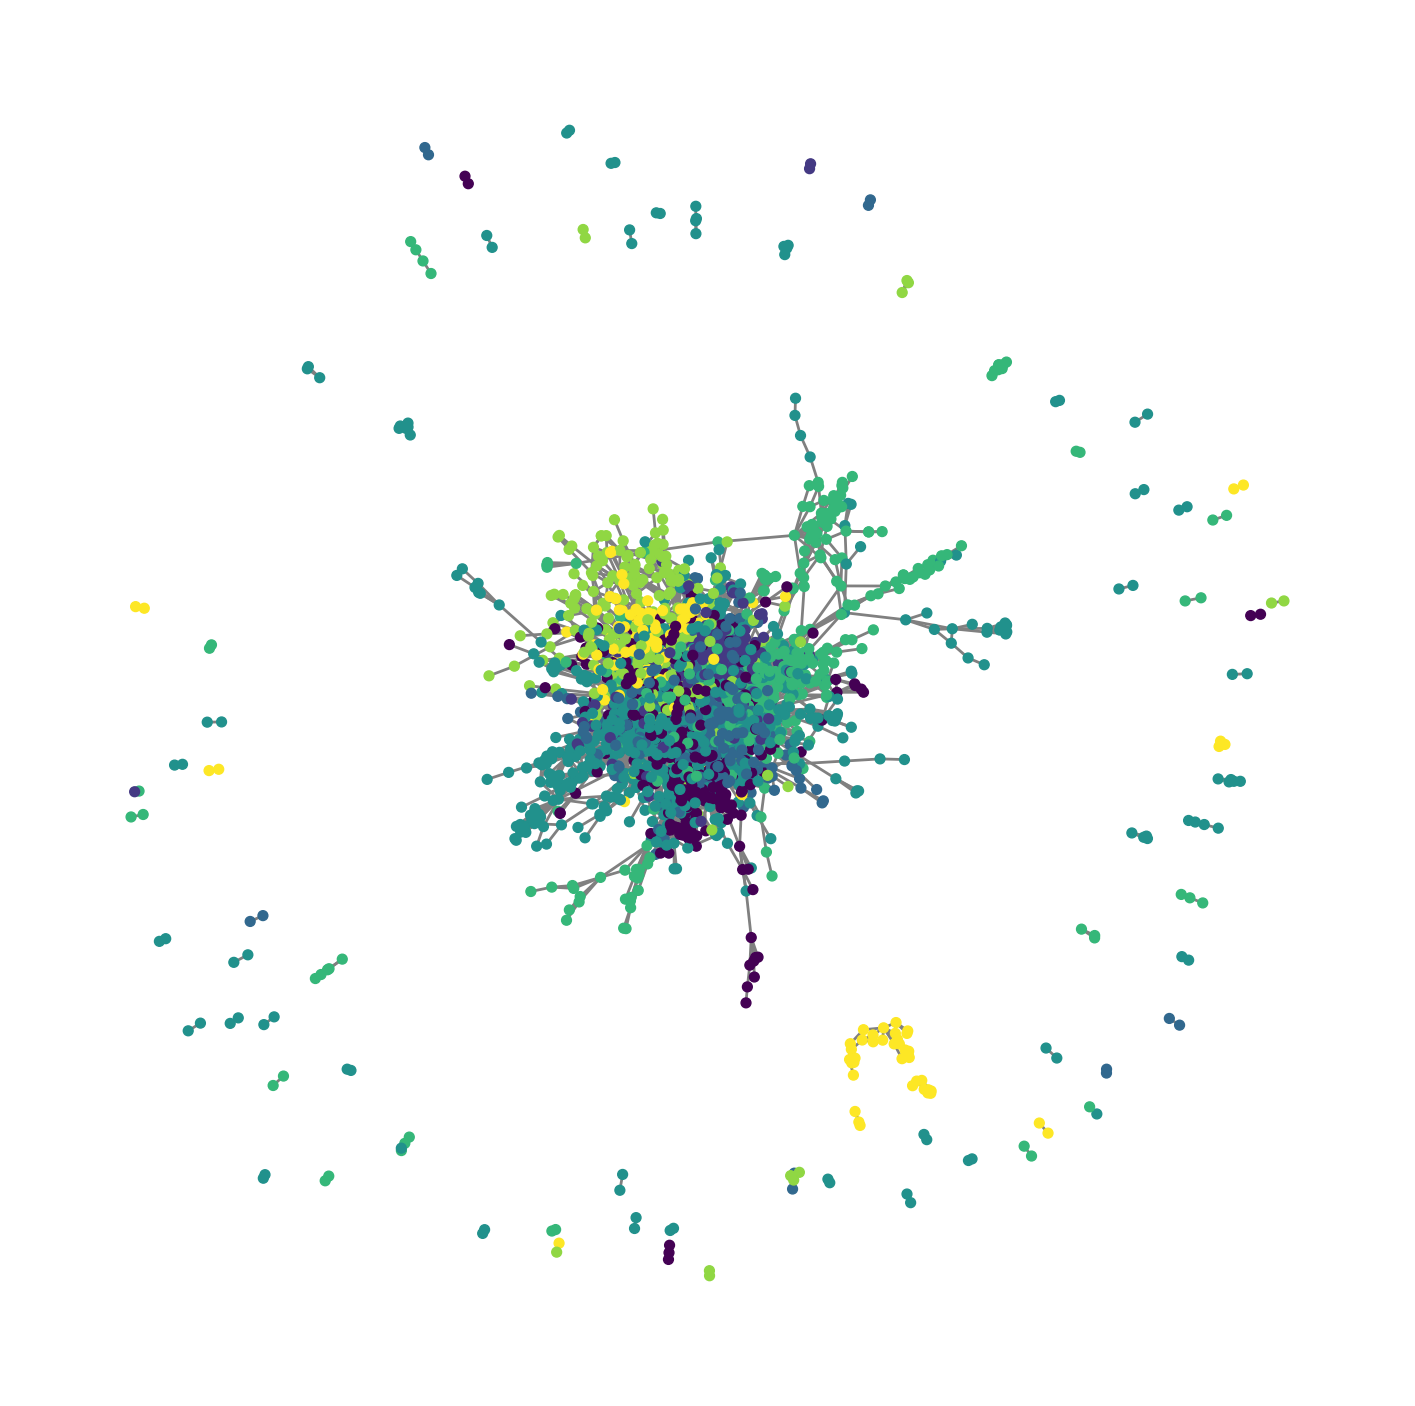

In [ ]:
# Visualize the dataset
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw(G,
        pos=nx.spring_layout(G, seed=0),
        with_labels=False,
        node_size=50,
        node_color=data.y,
        width=2,
        edge_color="grey"
                )
plt.show()

## 2. Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self,input_dim, hidden_size, output_dim, dropout = 0.5):
        super(MLP, self).__init__()
        torch.manual_seed(123)
        self.dropout = dropout
        self.fc1 = nn.Linear(input_dim , hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = F.dropout(out, p= self.dropout, training=self.training)
        out = self.fc2(out)
        return out

In [ ]:
model_mlp = MLP(input_dim = dataset.num_features, hidden_size = 64, output_dim = dataset.num_classes, dropout = 0.5)
print(model_mlp)

MLP(
  (fc1): Linear(in_features=1433, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=7, bias=True)
)


In [ ]:
def train(model, optimizer):
    model.train()
    optimizer.zero_grad() # Clear gradients
    out = model(data.x) # Perform a single forward pass
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Compute the loss solely based on the training nodes
    train_loss.backward() # Derive gradients
    optimizer.step() # Update parameters based on gradients
    return train_loss.item()

def evaluate(model, mask):
    model.eval()
    with torch.no_grad(): # No gradient in eval
        out = model(data.x)
        loss = criterion(out[mask], data.y[mask]) # Compute the loss based on the validation/test nodes
        pred = out[mask].argmax(dim=1)  # Use the class with highest probability
        eval_correct = pred == data.y[mask]  # Check against ground-truth labels
        acc = int(eval_correct.sum().item()) / int(len(data.y[mask]))  # Derive ratio of correct predictions
    return acc, loss.item()

Epoch: 000, Train Loss: 1.9456, Val Loss: 1.9366, Val Acc: 0.0840
Epoch: 001, Train Loss: 1.8737, Val Loss: 1.9162, Val Acc: 0.2520
Epoch: 002, Train Loss: 1.7894, Val Loss: 1.8888, Val Acc: 0.4000
Epoch: 003, Train Loss: 1.6915, Val Loss: 1.8550, Val Acc: 0.4780
Epoch: 004, Train Loss: 1.5646, Val Loss: 1.8146, Val Acc: 0.5180
Epoch: 005, Train Loss: 1.4163, Val Loss: 1.7688, Val Acc: 0.5600
Epoch: 006, Train Loss: 1.2684, Val Loss: 1.7188, Val Acc: 0.5760
Epoch: 007, Train Loss: 1.0979, Val Loss: 1.6665, Val Acc: 0.5880
Epoch: 008, Train Loss: 0.9528, Val Loss: 1.6139, Val Acc: 0.5920
Epoch: 009, Train Loss: 0.7643, Val Loss: 1.5617, Val Acc: 0.5920
Epoch: 010, Train Loss: 0.6546, Val Loss: 1.5106, Val Acc: 0.5940
Epoch: 011, Train Loss: 0.5140, Val Loss: 1.4625, Val Acc: 0.5920
Epoch: 012, Train Loss: 0.4188, Val Loss: 1.4183, Val Acc: 0.5940
Epoch: 013, Train Loss: 0.3601, Val Loss: 1.3795, Val Acc: 0.5900
Epoch: 014, Train Loss: 0.2549, Val Loss: 1.3466, Val Acc: 0.5920
Epoch: 015

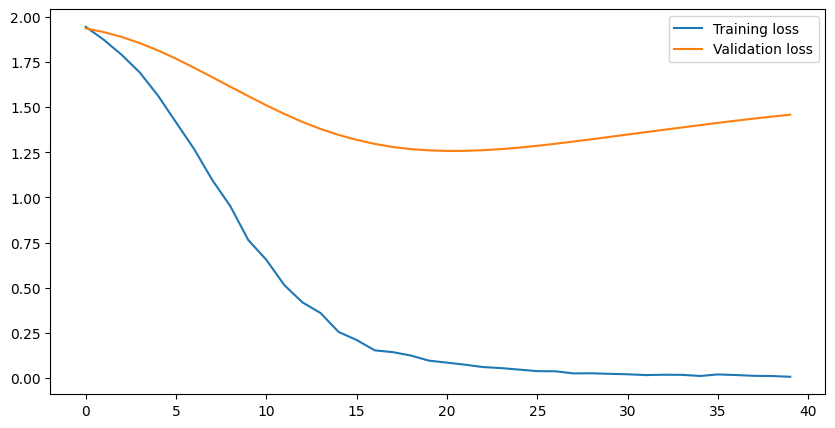

In [ ]:
model_mlp = MLP(input_dim = dataset.num_features, hidden_size = 128, output_dim = dataset.num_classes, dropout = 0.6)
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.005, weight_decay=5e-05) # Define optimizer.
criterion = torch.nn.CrossEntropyLoss() # Define loss criterion.

train_loss_list = []
val_loss_list = []
best_val_loss = np.inf

for epoch in range(40):
    train_loss = train(model_mlp, optimizer) 
    # Evaluate the model_mlp on the validation set
    val_acc, val_loss = evaluate(model_mlp, data.val_mask)
    train_loss_list.append(train_loss) 
    val_loss_list.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_val_acc = val_acc
        # best_model_mlp = model_mlp.state_dict()
        torch.save(model_mlp.state_dict(), 'model_mlp.pt')
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

print('Best Validation Loss: {:.4f}'.format(best_val_loss))
print('Best Epoch: {}'.format(best_epoch))
print('Best Validation Accuracy: {:.2f} %'.format(best_val_acc*100))

# Evaluate the model_mlp on the test set at lowest validation loss
model_mlp.load_state_dict(torch.load('model_mlp.pt'))
test_acc, _ = evaluate(model_mlp, data.test_mask)
print('Test Accuracy: {:.2f} %'.format(test_acc*100))

plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training loss')
plt.plot(val_loss_list, label='Validation loss')
plt.legend()
plt.show()

## 3.Graph Convolution Network (GCN)
We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on the first part of this tutorial We replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

### Schematic depiction of multi-layer Graph Convolutional Network (GCN): 
for semisupervised learning with $C$ input channels and $F$ feature maps in the output layer.The graph structure (edges shown as black lines) is shared over layers,labels are denoted by $
\mathbf{Y_i}$


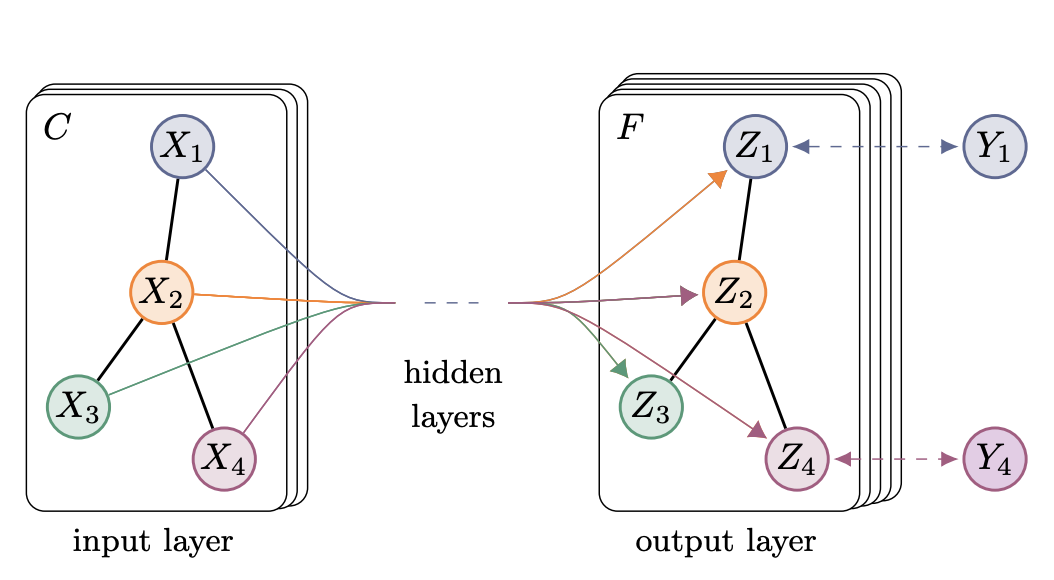

For 2 GCN layers matrix equation will be:
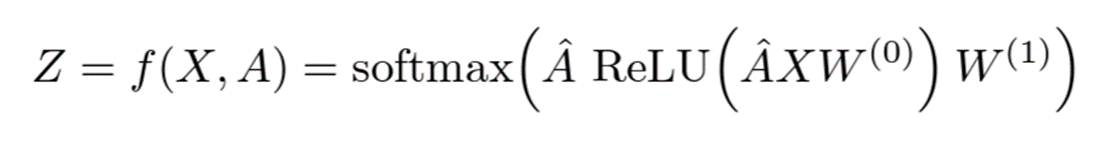

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, input_dim, hidden_size, output_dim, dropout = 0.5):
    super().__init__()
    torch.manual_seed(123)
    self.dropout = dropout
    self.gcn1 = GCNConv(input_dim , hidden_size)
    self.gcn2 = GCNConv(hidden_size,output_dim)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=self.dropout, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=self.dropout, training=self.training)
    h = self.gcn2(h, edge_index)
    h = F.log_softmax(h, dim=1)
    return h

In [ ]:
def train(model):
    model.train()
    optimizer.zero_grad() # Clear gradients
    out = model(data.x, data.edge_index) # Perform a single forward pass
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Compute the loss solely based on the training nodes
    train_loss.backward() # Derive gradients
    optimizer.step() # Update parameters based on gradients
    return train_loss.item()

def evaluate(model, mask):
    model.eval()
    with torch.no_grad(): # No gradient in eval
        out = model(data.x, data.edge_index)
        loss = criterion(out[mask], data.y[mask]) # Compute the loss based on the validation/test nodes
        pred = out[mask].argmax(dim=1)  # Use the class with highest probability
        eval_correct = pred == data.y[mask]  # Check against ground-truth labels
        acc = int(eval_correct.sum().item()) / int(len(data.y[mask]))  # Derive ratio of correct predictions
    return acc, loss.item()

Epoch: 000, Train Loss: 1.9508, Val Loss: 1.8224, Val Acc: 0.6560
Epoch: 001, Train Loss: 1.7786, Val Loss: 1.6833, Val Acc: 0.7420
Epoch: 002, Train Loss: 1.5397, Val Loss: 1.5150, Val Acc: 0.7540
Epoch: 003, Train Loss: 1.2886, Val Loss: 1.3356, Val Acc: 0.7740
Epoch: 004, Train Loss: 1.0341, Val Loss: 1.1639, Val Acc: 0.7820
Epoch: 005, Train Loss: 0.8237, Val Loss: 1.0139, Val Acc: 0.7900
Epoch: 006, Train Loss: 0.6534, Val Loss: 0.8894, Val Acc: 0.7880
Epoch: 007, Train Loss: 0.5173, Val Loss: 0.7993, Val Acc: 0.7900
Epoch: 008, Train Loss: 0.4209, Val Loss: 0.7314, Val Acc: 0.7960
Epoch: 009, Train Loss: 0.3284, Val Loss: 0.6839, Val Acc: 0.7940
Epoch: 010, Train Loss: 0.2436, Val Loss: 0.6557, Val Acc: 0.7960
Epoch: 011, Train Loss: 0.2538, Val Loss: 0.6457, Val Acc: 0.8000
Epoch: 012, Train Loss: 0.2144, Val Loss: 0.6615, Val Acc: 0.7960
Epoch: 013, Train Loss: 0.1514, Val Loss: 0.6821, Val Acc: 0.7920
Epoch: 014, Train Loss: 0.1144, Val Loss: 0.7022, Val Acc: 0.7800
Epoch: 015

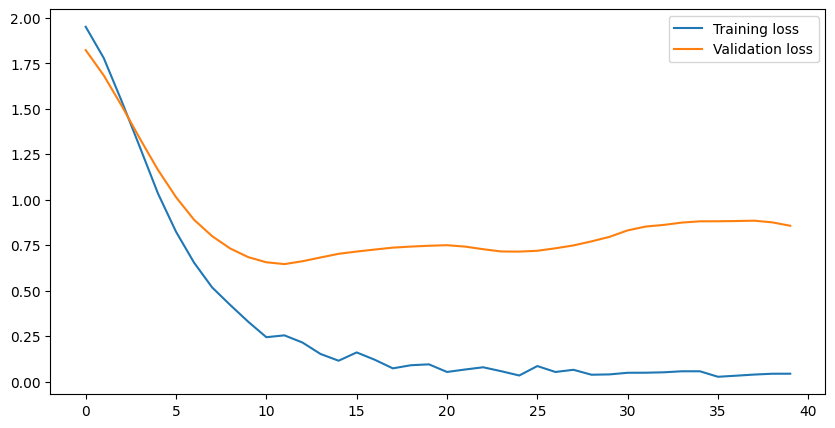

In [ ]:
model_gcn = GCN(input_dim = dataset.num_features, hidden_size = 128, output_dim =dataset.num_classes, dropout = 0.7)
data = dataset[0]

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.01, weight_decay=5e-4)

train_loss_list = []
val_loss_list = []
best_val_loss = np.inf

for epoch in range(40):
    train_loss = train(model_gcn)
    # Evaluate the model_gcn on the validation set
    val_acc, val_loss = evaluate(model_gcn, data.val_mask)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_val_acc = val_acc
        # best_model_gcn = model_gcn.state_dict()
        torch.save(model_gcn.state_dict(), 'model_gcn.pt')
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

print('Best Validation Loss: {:.4f}'.format(best_val_loss))
print('Best Epoch: {}'.format(best_epoch))
print('Best Validation Accuracy: {:.2f} %'.format(best_val_acc*100))

# Evaluate the model_gcn on the test set at lowest validation loss
model_gcn.load_state_dict(torch.load('model_gcn.pt'))
test_acc, _ = evaluate(model_gcn, data.test_mask)
print('Test Accuracy: {:.2f} %'.format(test_acc*100))

plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Training loss')
plt.plot(val_loss_list, label='Validation loss')
plt.legend()
plt.show()

### Visualization

In [ ]:
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

#### untrained model
Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

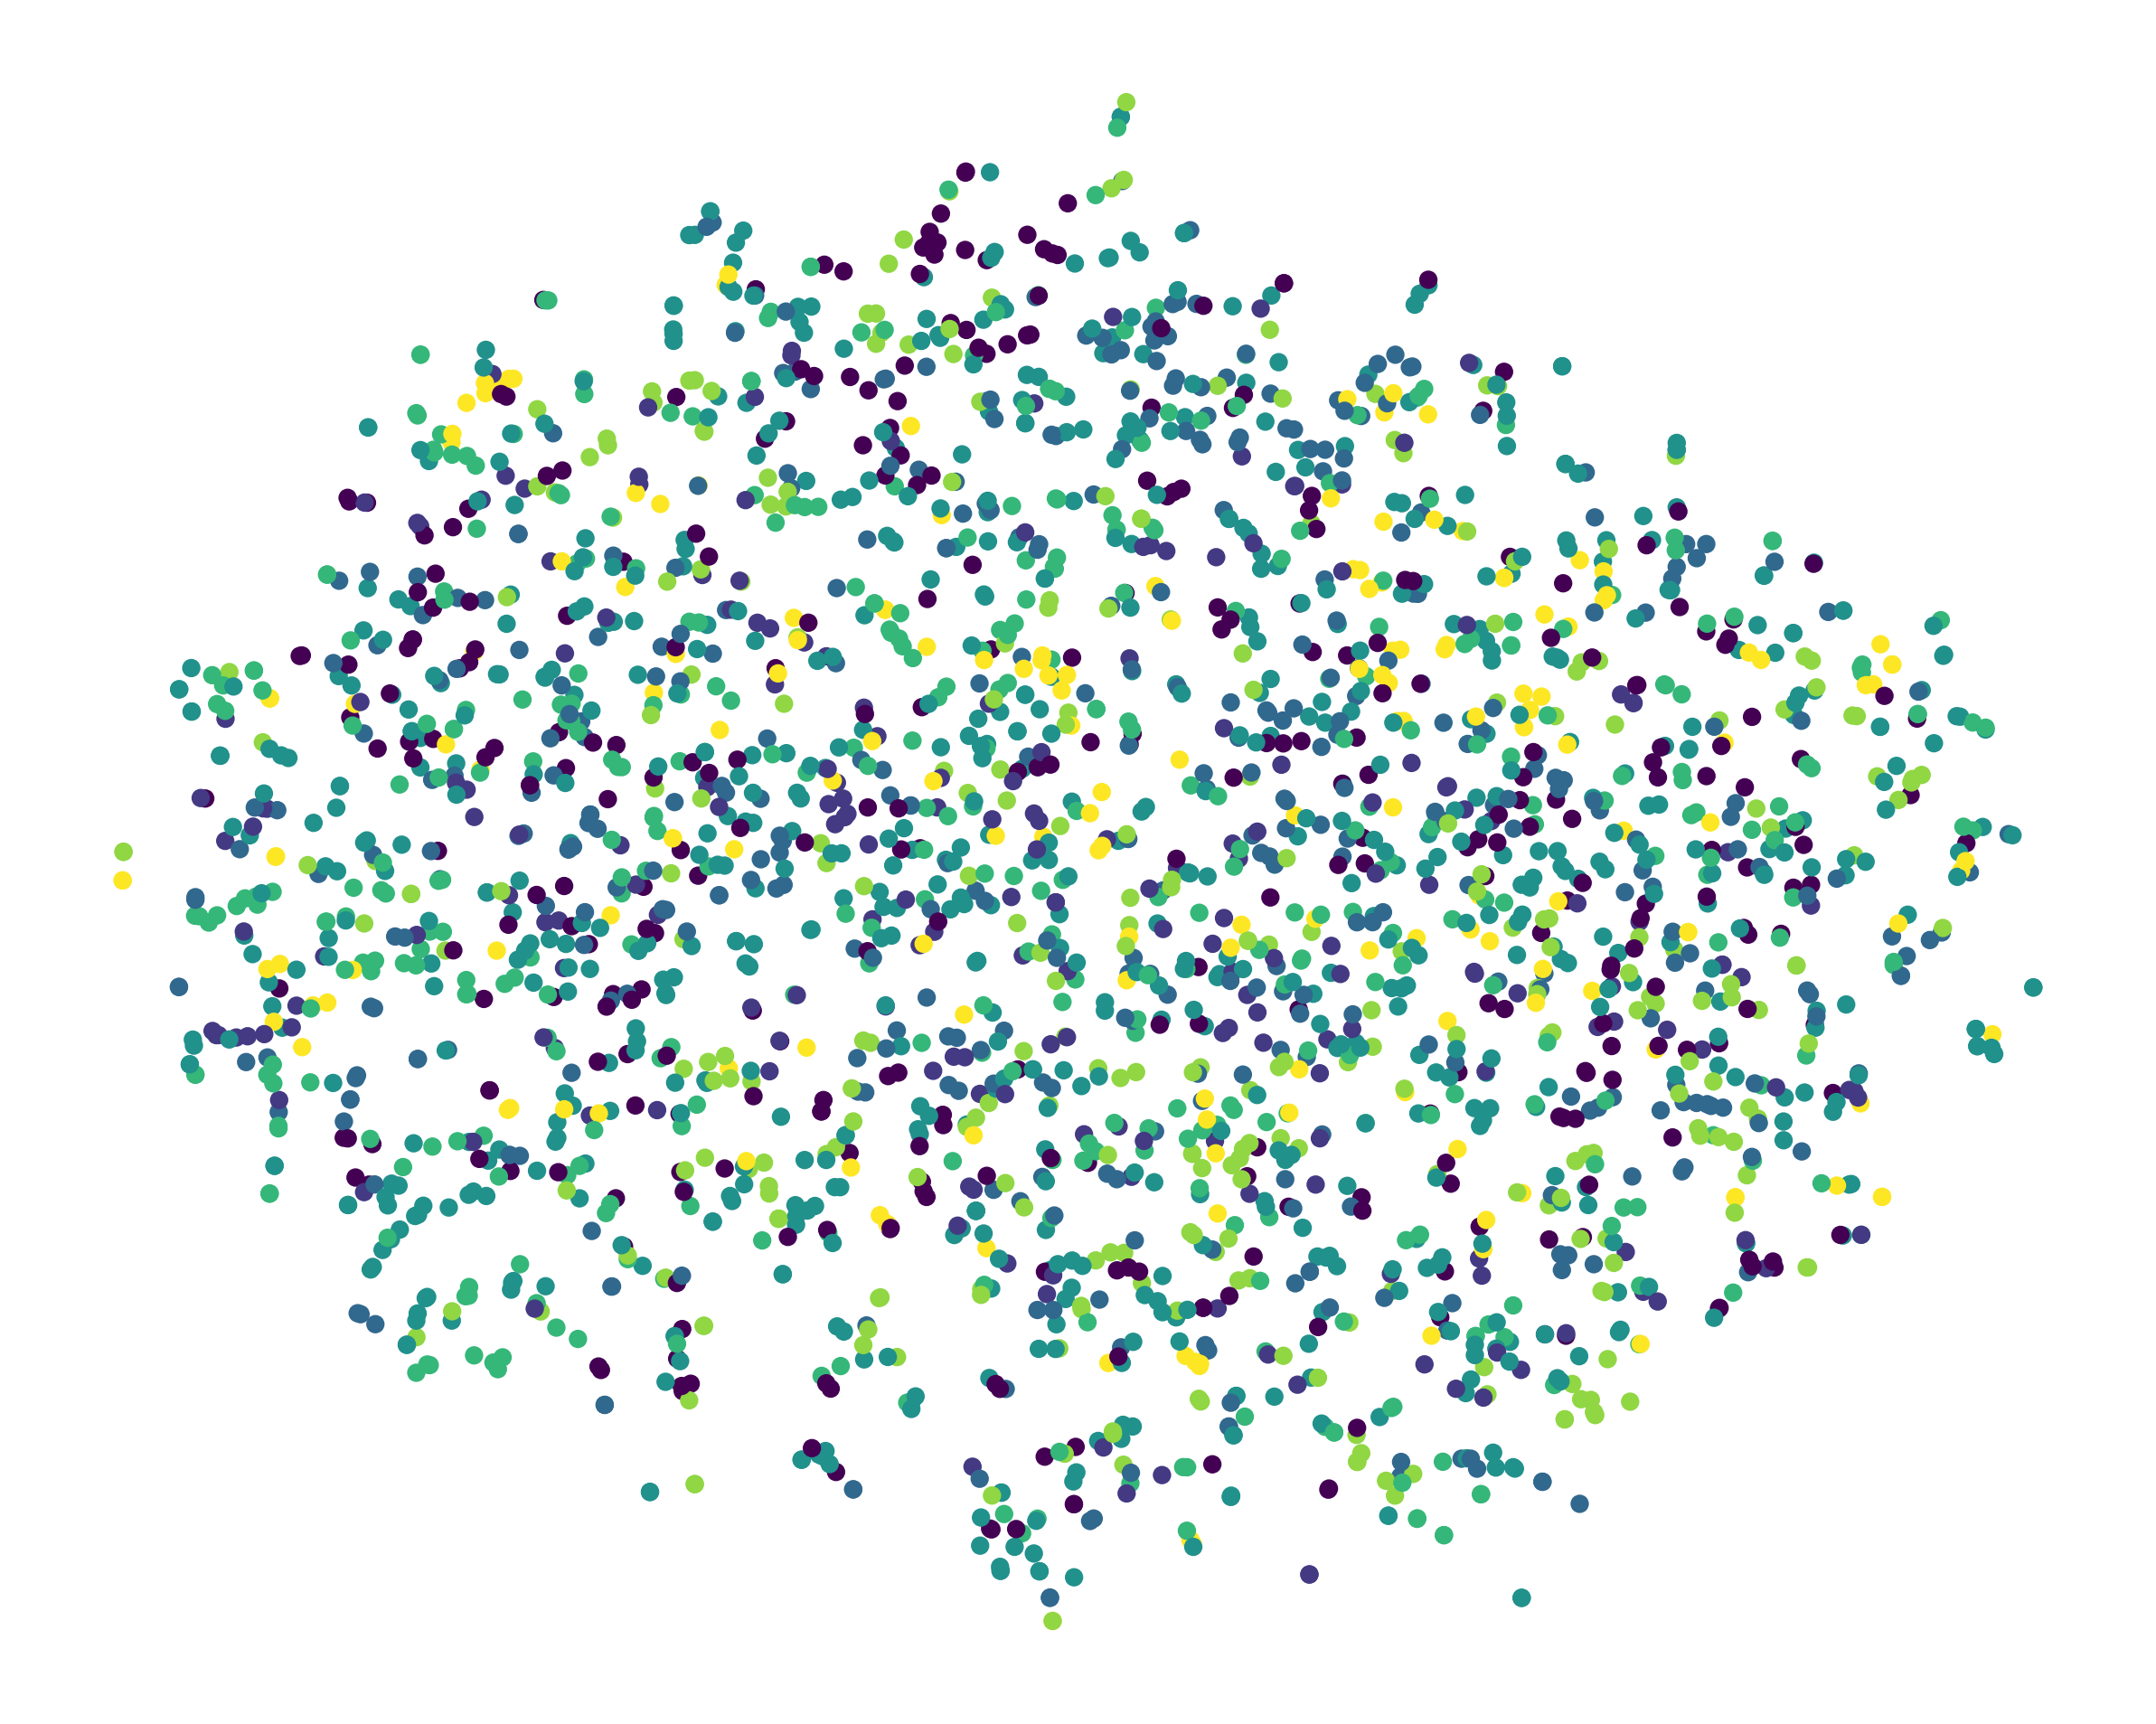

In [ ]:
# Initialize new untrained model
untrained_gcn = GCN(input_dim = dataset.num_features, hidden_size = 128, output_dim =dataset.num_classes, dropout = 0.7)

# Get embeddings
h = untrained_gcn(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s= 15, c=data.y)
plt.show()

#### Classification after MLP
We can do better by training our model.
We make use of only node features `x` as input to our MLP model.

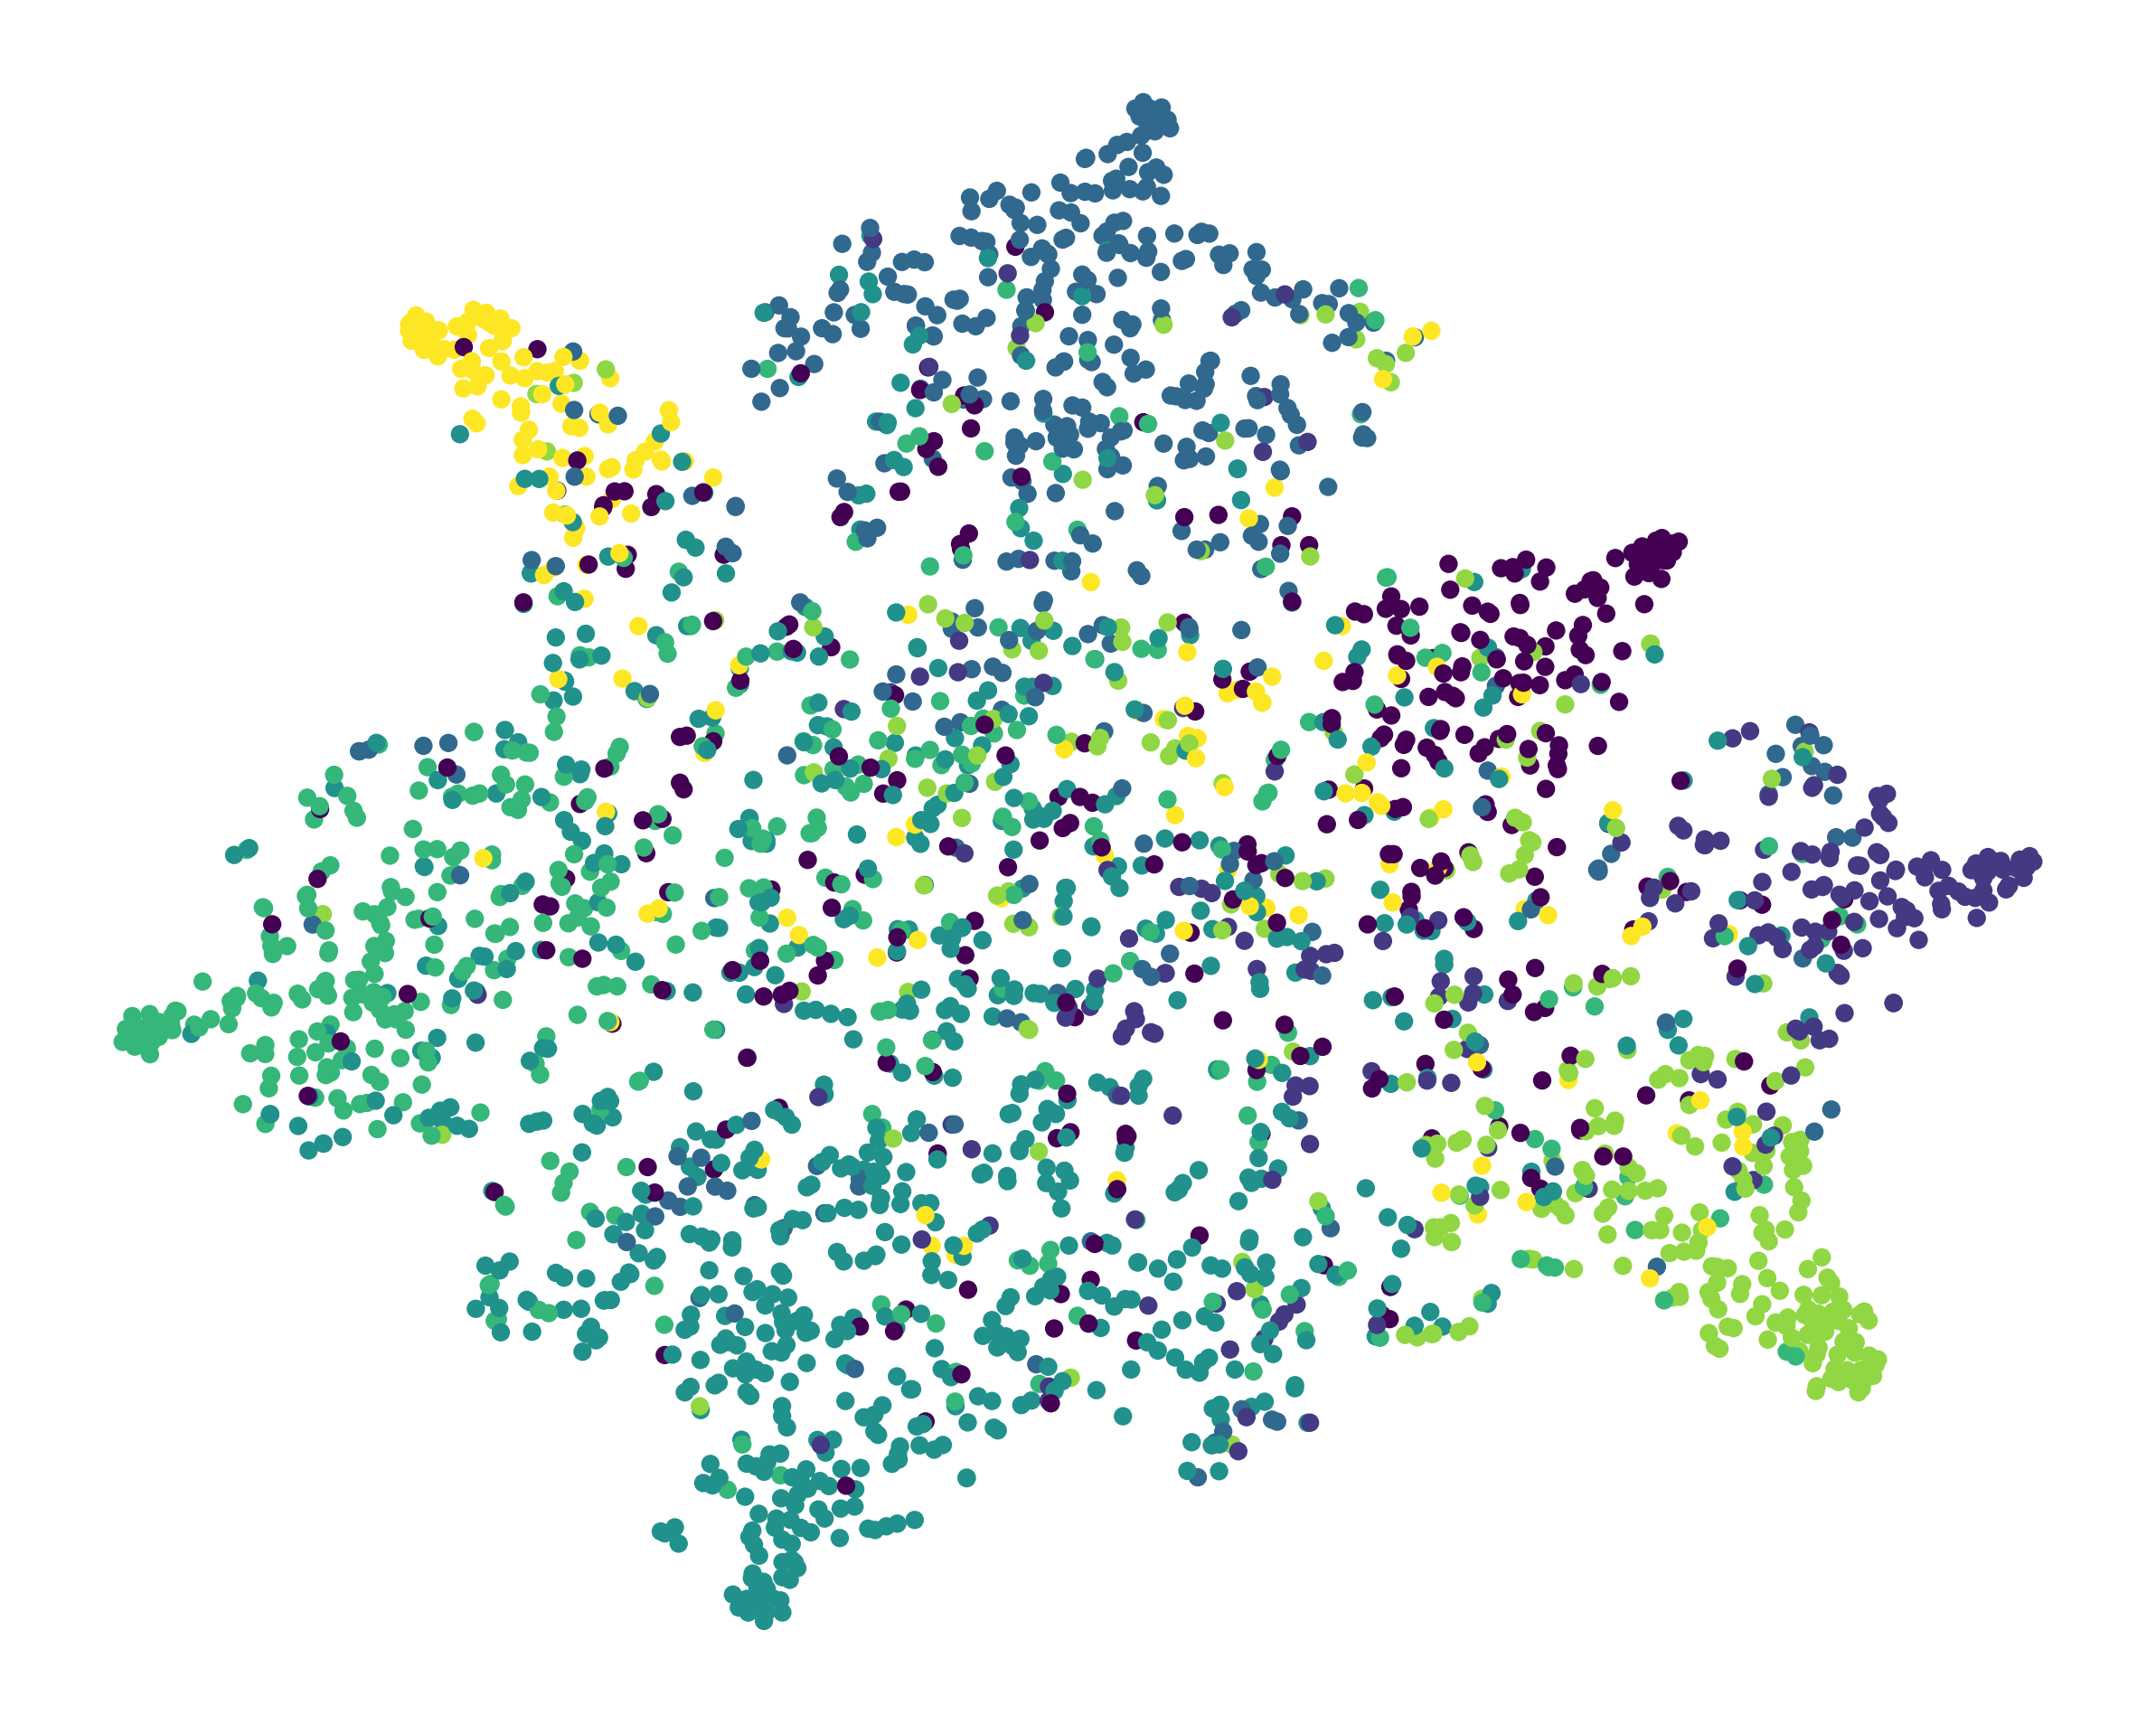

In [ ]:
# Get embeddings
h = model_mlp(data.x)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s= 15, c=data.y)
plt.show()

#### Classification after GCN
We certainly can do even better than MLP by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

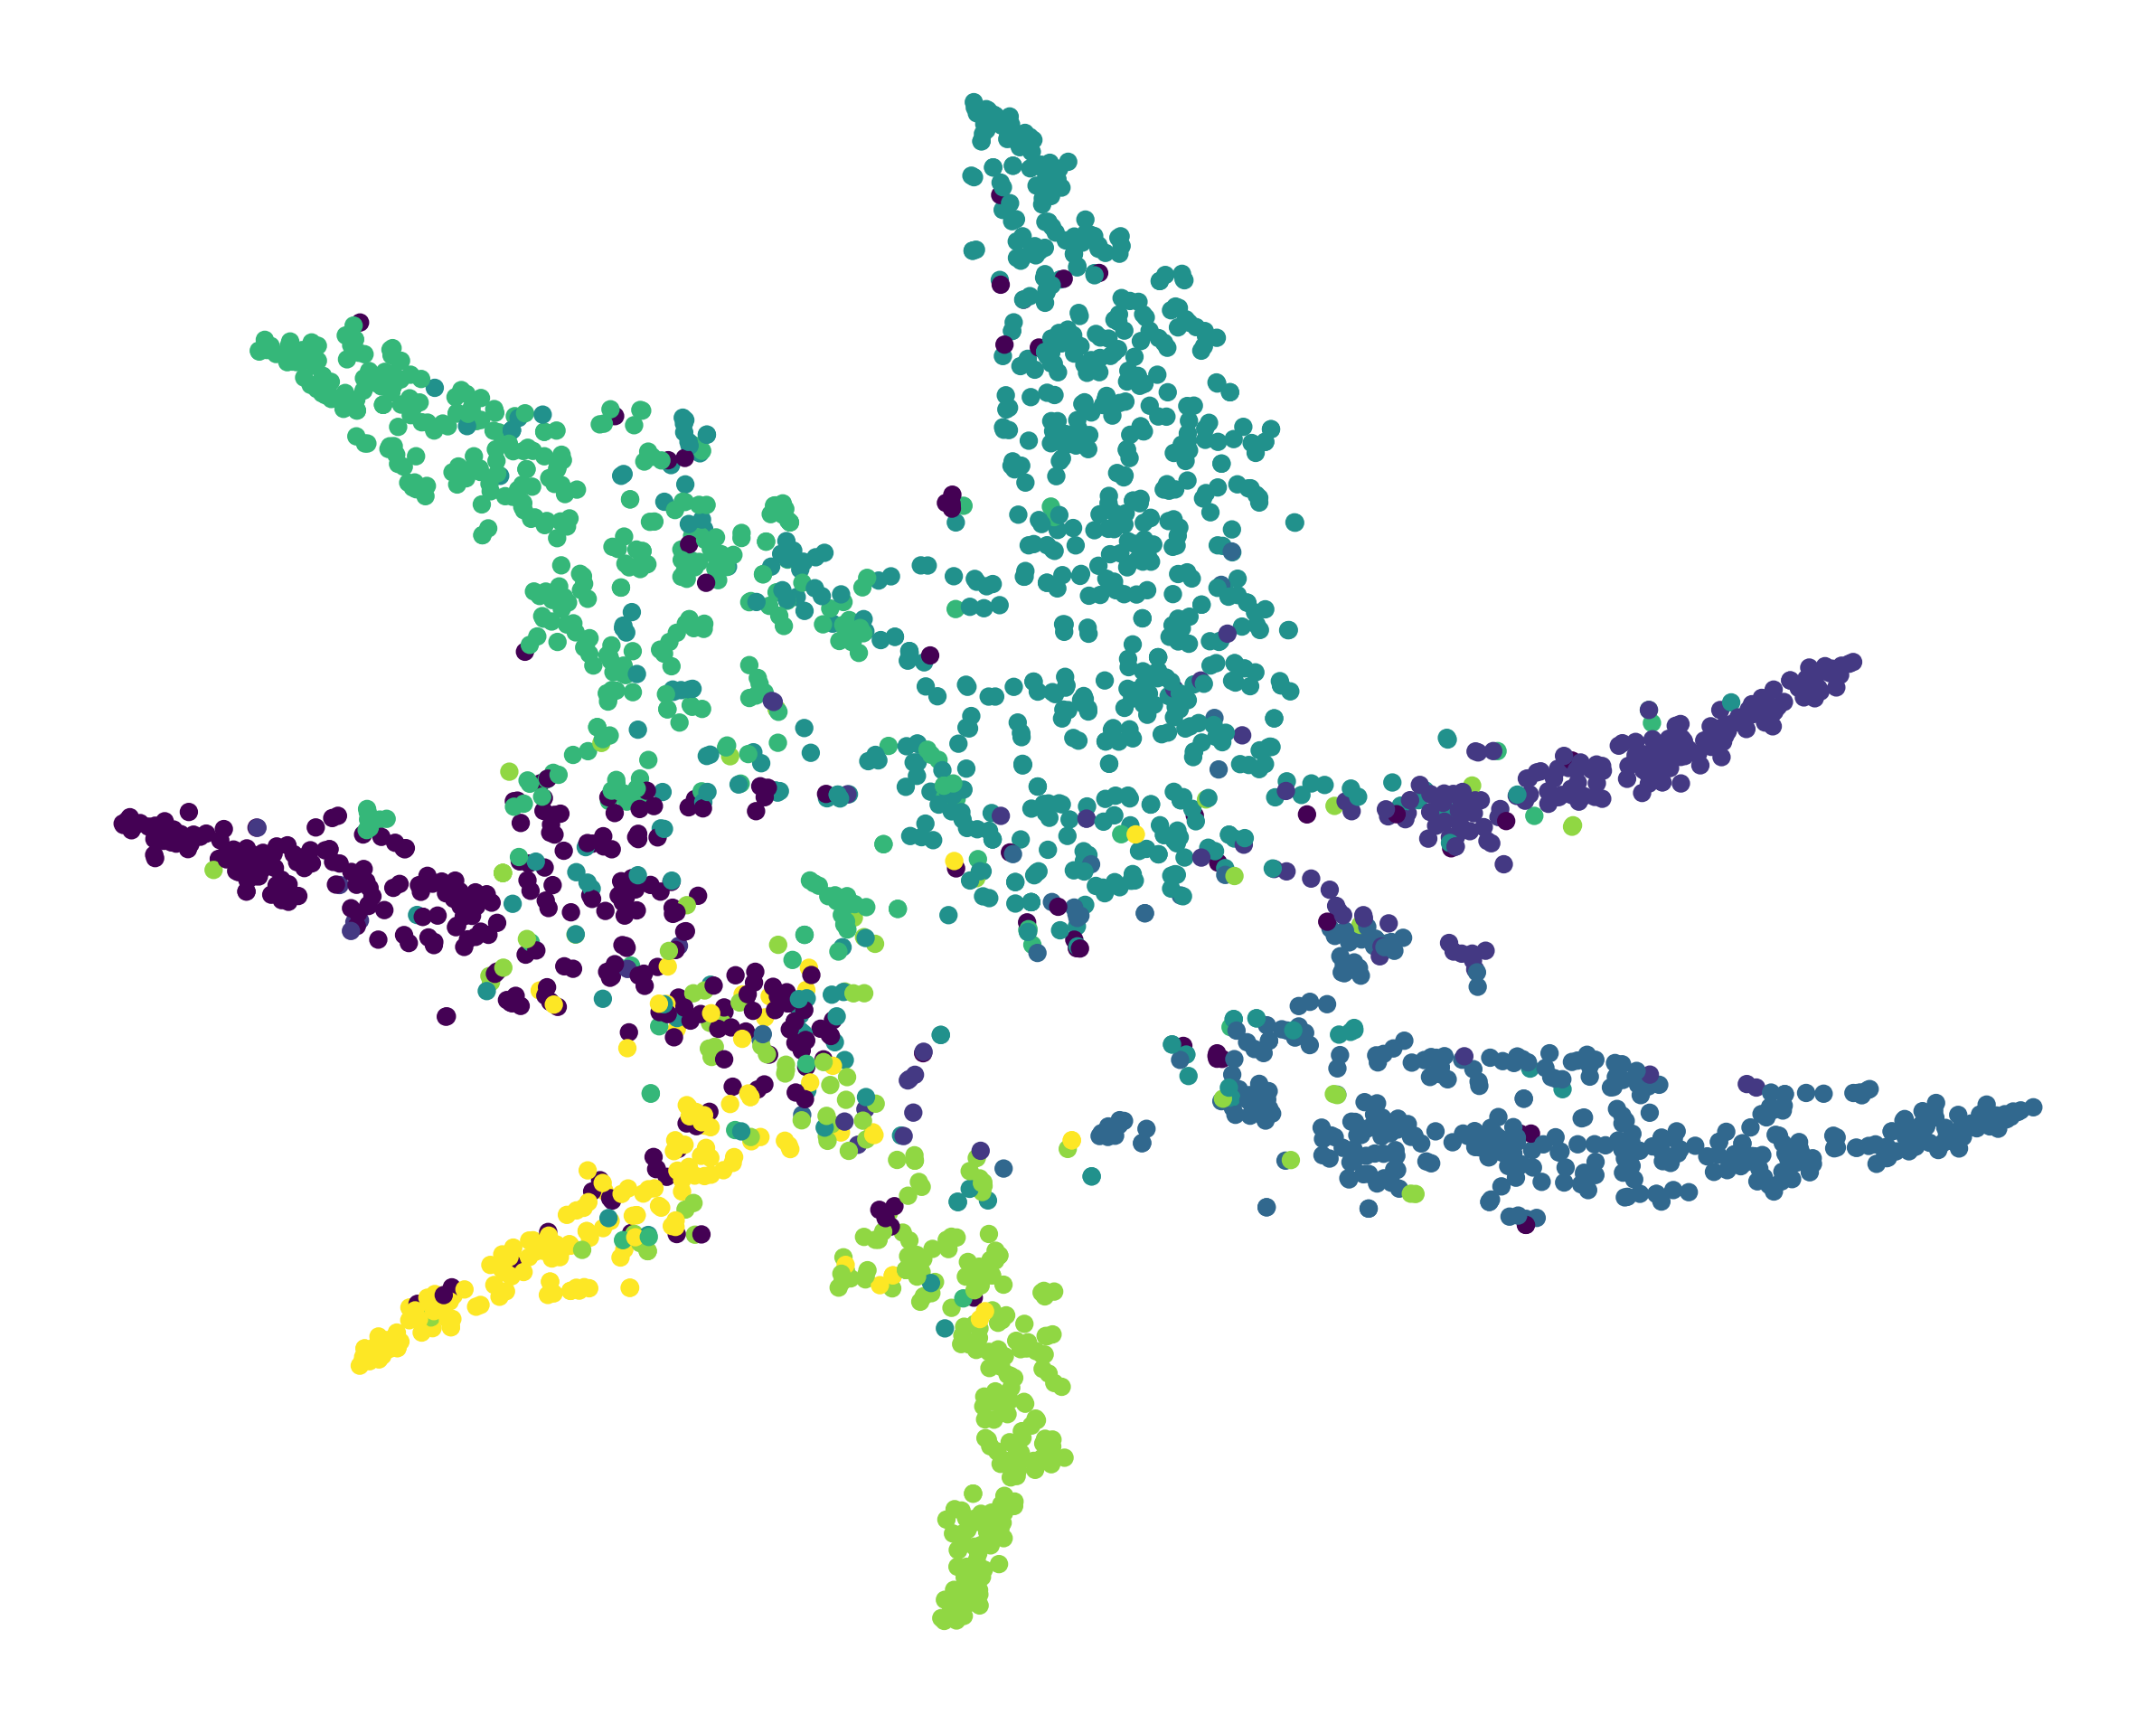

In [ ]:
# Get embeddings
h = model_gcn(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s= 15, c=data.y)
plt.show()

## Resources:
1. https://youtu.be/GXhBEj1ZtE8 # Motivation of GNN

2. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html # PyG GCNConv

3. https://youtu.be/F3PgltDzllc # CS224W Lecture 6

4. https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html # Official PyG Tutorials

5. https://youtu.be/JtDgmmQ60x8 # Lec 1 & 3

## Let's Connect:

[LinkedIn](https://www.linkedin.com/in/jayadratha-gayen/)